In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import torch

from collections import namedtuple
from itertools import chain
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Load data
path = '../data/metadata/'

#Ratings
# ratings = pd.read_csv(path+'ratings.dat', sep='::', header=None, engine='python')
# ratings.columns = ['userId','movieId','rating','timestamp']
# ratings = ratings.drop('timestamp', axis=1)
# ratings = pd.read_csv(path+'user_item_rating_2.csv')   #, sep=',', header=None, engine='python')
ratings = pd.read_csv(path+'user_item_rating_all_200w.csv')   #, sep=',', header=None, engine='python')
ratings.columns = ['user','song','rating']
ratings.info(verbose=True, max_cols=True, memory_usage=True, null_counts=True)

# data
# data = pd.read_csv(path+'track_200w.csv')
data = pd.read_csv(path+'track_all_200w.csv')
# data = data[['user','song','play_count','year','tags']]
data.info(verbose=True, max_cols=True, memory_usage=True, null_counts=True)
data.head(10)
data.astype({'user': 'int32', 'song': 'int32', 'play_count': 'int32', 'year': 'int32'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2052374 entries, 0 to 2052373
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    2052374 non-null  int64  
 1   song    2052374 non-null  int64  
 2   rating  2052374 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 47.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2052374 entries, 0 to 2052373
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   user                2052374 non-null  int64  
 1   song                2052374 non-null  int64  
 2   play_count          2052374 non-null  int64  
 3   track_id            2052374 non-null  object 
 4   title               2052369 non-null  object 
 5   release             2052374 non-null  object 
 6   artist_name         2052374 non-null  object 
 7   artist_familiarity  2052374 non-null  float64
 8   artist_hotttne

,user,song,play_count,track_id,title,release,artist_name,artist_familiarity,artist_hotttnesss,year
0,29990,3209,1,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
1,20160,3209,1,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
2,19083,3209,3,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
3,5860,3209,1,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
4,10262,3209,6,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
...,...,...,...,...,...,...,...,...,...,...
2052369,7683,91997,1,TRUHAMV128E078E018,My How The Time Goes By,The Best Of The Fourmost,The Fourmost,0.457509,0.352143,1992
2052370,7683,92203,4,TREMXLV128F92F202E,You Follow Me,Loose & Juicy,James Moody,0.519558,0.402892,0
2052371,7683,98789,2,TRTCYIO128F933A649,Cell,Strange In Stereo,In The Woods,0.573120,0.456013,1999
2052372,7683,137669,5,TRVUXXA128F930B25E,Johanna,Back to the Noise,Iggy & The Stooges,0.732603,0.486804,1981


In [ ]:
# # 字典user_playcounts记录每个用户的播放总量
# user_playcounts = {}
# for user, group in data.groupby('user'):
#     user_playcounts[user] = group['play_count'].sum()
# temp_user = [user for user in user_playcounts.keys() if user_playcounts[user] > 100]
# temp_playcounts = [playcounts for user, playcounts in user_playcounts.items() if playcounts > 100]
# # data = data[data.user.isin(temp_user)]
# ratings = ratings[ratings.user.isin(temp_user)]
# print('歌曲播放量大于100的用户数量占总体用户数量的比例为', str(round(len(temp_user)/len(user_playcounts), 4)*100)+'%')
# print('歌曲播放量大于100的用户产生的播放总量占总体播放总量的比例为', str(round(sum(temp_playcounts) / sum(user_playcounts.values())*100, 4))+'%')
# print('歌曲播放量大于100的用户产生的数据占总体数据的比例为', str(round(len(data[data.user.isin(temp_user)])/len(data)*100, 4))+"%")



# song_playcounts字典，记录每首歌的播放量
# song_playcounts = {}
# for song, group in data.groupby('song'):
#     song_playcounts[song] = group['play_count'].sum()
# temp_song = [song for song in song_playcounts.keys() if song_playcounts[song] > 50]
# temp_playcounts = [playcounts for song, playcounts in song_playcounts.items() if playcounts > 50]
# # data = data[data.song.isin(temp_song)]
# ratings = ratings[ratings.song.isin(temp_song)]
# print('播放量大于50的歌曲数量占总体歌曲数量的比例为', str(round(len(temp_song)/len(song_playcounts), 4)*100)+'%')
# print('播放量大于50的歌曲产生的播放总量占总体播放总量的比例为', str(round(sum(temp_playcounts) / sum(song_playcounts.values())*100, 4))+'%')
# print('播放量大于50的歌曲产生的数据占总体数据的比例为', str(round(len(data[data.song.isin(temp_song)])/len(data)*100, 4))+"%")


print("data:****************************************")
data.info(verbose=True, max_cols=True, memory_usage=True, null_counts=True)


#songs
# movies = pd.read_csv(path+'movies.dat', sep='::', header=None, engine='python')
# movies.columns = ['movieId','Title','Genres']
songs = data[['song','year']]
songs = songs.rename(columns={'year': 'song_year'})
# 根据songID去重
songs.drop_duplicates(subset=['song'],keep='first',inplace=True)
songs.info(verbose=True, max_cols=True, memory_usage=True, null_counts=True)
# 去除year为0
songs = songs[songs.song_year != 0]
songs.head(10)
songs.info(verbose=True, max_cols=True, memory_usage=True, null_counts=True)

# 评分中year为0的歌曲去除
song_with_year = [song for song in songs.song]
ratings = ratings[ratings.song.isin(song_with_year)]
del(song_with_year)
# song_with_year.head(10)
# song_with_year.info(verbose=True, max_cols=True, memory_usage=True, null_counts=True)
#Users
# users = pd.read_csv(path+'users.dat', sep='::', header=None, engine='python')
# users.columns = ['userId','Gender','Age','Occupation','Zip-code']
# users = users.drop('Zip-code', axis=1)
# user没有附加信息
# users = data[['user']]

歌曲播放量大于100的用户数量占总体用户数量的比例为 40.32%
歌曲播放量大于100的用户产生的播放总量占总体播放总量的比例为 80.8776%
歌曲播放量大于100的用户产生的数据占总体数据的比例为 71.9577%
data:****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2052374 entries, 0 to 2052373
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   user                2052374 non-null  int64  
 1   song                2052374 non-null  int64  
 2   play_count          2052374 non-null  int64  
 3   track_id            2052374 non-null  object 
 4   title               2052369 non-null  object 
 5   release             2052374 non-null  object 
 6   artist_name         2052374 non-null  object 
 7   artist_familiarity  2052374 non-null  float64
 8   artist_hotttnesss   2052374 non-null  float64
 9   year                2052374 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 156.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 193

In [ ]:
#Data quality
print('Duplicated rows in ratings file: ' + str(ratings.duplicated().sum()))

# n_users = ratings.userId.unique().shape[0]
# n_movies = ratings.movieId.unique().shape[0]
n_users = ratings.user.unique().shape[0]
n_songs = ratings.song.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of songs: {}'.format(n_songs))
print('Sparsity: {:4.3f}%'.format(float(ratings.shape[0]) / float(n_users*n_songs) * 100))

# all


# user>100


# song>50


# user>100 and song>50


Duplicated rows in ratings file: 32486
Number of users: 16837
Number of songs: 130006
Sparsity: 0.055%


In [ ]:
ratings.shape
print('ratings*************************')
ratings.head(10)
print('songs*************************')
songs.head(10)

ratings*************************
songs*************************


,song,song_year
96,4702,1974
124,8475,1976
210,9707,2002
249,13918,2006
277,14658,2002
284,15231,2008
305,15307,2007
1525,15622,2005
1805,20279,2006
1841,24070,1999


In [ ]:
# 评分和歌曲连接
# final_df = ratings.merge(songs, left_on='song', right_on='song', how='inner')
final_df = pd.merge(ratings,songs,how='left',on="song")
# user、song不按照播放量筛选：1648992条数据 
final_df.info(verbose=True, max_cols=True, memory_usage=True, null_counts=True)

n_users = final_df.user.unique().shape[0]
n_songs = final_df.song.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of songs: {}'.format(n_songs))
print('Sparsity: {:4.3f}%'.format(float(final_df.shape[0]) / float(n_users*n_songs) * 100))




<class 'pandas.core.frame.DataFrame'>
Int64Index: 1194539 entries, 0 to 1194538
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1194539 non-null  int64  
 1   song       1194539 non-null  int64  
 2   rating     1194539 non-null  float64
 3   song_year  1194539 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 45.6 MB
Number of users: 16837
Number of songs: 130006
Sparsity: 0.055%


In [ ]:
final_df.head(10)  

# 释放内存
del(ratings)
del(data)

### 数据处理

In [ ]:
def encoder(df, cols=None):
    if cols == None:
        cols = list(df.select_dtypes(include=['object']).columns)

    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()
    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x])

    return val_to_idx, df

In [ ]:
def data_processing(df, wide_cols, embeddings_cols, continuous_cols, target,
                    scale=False, def_dim=8):


    if type(embeddings_cols[0]) is tuple:
        emb_dim = dict(embeddings_cols)
        embeddings_cols = [emb[0] for emb in embeddings_cols]
    else:
        emb_dim = {e:def_dim for e in embeddings_cols}
    deep_cols = embeddings_cols+continuous_cols

    # Extract the target and copy the dataframe so we don't mutate it
    # internally.
    Y = np.array(df[target])
    all_columns = list(set(wide_cols + deep_cols ))
    df_tmp = df.copy()[all_columns]


    # 提取可在以后进行热编码的分类列名
    categorical_columns = list(df_tmp.select_dtypes(include=['object']).columns)


    encoding_dict,df_tmp = encoder(df_tmp)
    encoding_dict = {k:encoding_dict[k] for k in encoding_dict if k in deep_cols}
    embeddings_input = []
    for k,v in encoding_dict.items():
        embeddings_input.append((k, len(v), emb_dim[k]))

    df_deep = df_tmp[deep_cols]
    deep_column_idx = {k:v for v,k in enumerate(df_deep.columns)}


    if scale:
        scaler = StandardScaler()
        for cc in continuous_cols:
            df_deep[cc]  = scaler.fit_transform(df_deep[cc].values.reshape(-1,1))

    df_wide = df_tmp[wide_cols]
    del(df_tmp)
    dummy_cols = [c for c in wide_cols if c in categorical_columns]
    df_wide = pd.get_dummies(df_wide, columns=dummy_cols)

    X_train_deep, X_test_deep = train_test_split(df_deep.values, test_size=0.3, random_state=1463)
    X_train_wide, X_test_wide = train_test_split(df_wide.values, test_size=0.3, random_state=1463)
    y_train, y_test = train_test_split(Y, test_size=0.3, random_state=1981)

    group_dataset = dict()
    train_dataset = namedtuple('train_dataset', 'wide, deep, labels')
    test_dataset  = namedtuple('test_dataset' , 'wide, deep, labels')
    group_dataset['train_dataset'] = train_dataset(X_train_wide, X_train_deep, y_train)
    group_dataset['test_dataset']  = test_dataset(X_test_wide, X_test_deep, y_test)
    group_dataset['embeddings_input']  = embeddings_input
    group_dataset['deep_column_idx'] = deep_column_idx
    group_dataset['encoding_dict'] = encoding_dict

    return group_dataset

### 数据设置

In [ ]:
#数据设置
# wide_cols = ['song_year','tags','user','song']
# embeddings_cols = [('tags',20), ('user',100), ('song',100)]
wide_cols = ['song_year','user','song']
embeddings_cols = [('user',100), ('song',100)]
crossed_cols = ()
continuous_cols = ["song_year"]
target = 'rating'

In [ ]:
#拆分数据并生成嵌入
data_processed = data_processing(
    final_df, wide_cols,
    embeddings_cols,
    continuous_cols,
    target,
    scale=True)

In [ ]:
use_cuda = torch.cuda.is_available()

#加载数据集
class DatasetLoader(Dataset):
    def __init__(self, data):

        self.X_wide = data.wide
        self.X_deep = data.deep
        self.Y = data.labels

    def __getitem__(self, idx):

        xw = self.X_wide[idx]
        xd = self.X_deep[idx]
        y  = self.Y[idx]

        return xw, xd, y

    def __len__(self):
        return len(self.Y)

### 类定义广度和深度神经网络

In [ ]:
#类定义广度和深度神经网络
class NeuralNet(nn.Module):

    def __init__(self,
                 wide_dim,
                 embeddings_input,
                 continuous_cols,
                 deep_column_idx,
                 hidden_layers,
                 dropout,
                 encoding_dict,
                 n_class):

        super(NeuralNet, self).__init__()
        self.wide_dim = wide_dim
        self.deep_column_idx = deep_column_idx
        self.embeddings_input = embeddings_input
        self.continuous_cols = continuous_cols
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.encoding_dict = encoding_dict
        self.n_class = n_class
        self.loss_values=[]

        # 创建要穿过深侧的嵌入层
        for col,val,dim in self.embeddings_input:
            setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))

        # 如果指定，则使用下拉框构建深侧隐藏层
        input_emb_dim = np.sum([emb[2] for emb in self.embeddings_input])
        # input_emb_dim为float64
        input_emb_dim = int(input_emb_dim)
        self.linear_1 = nn.Linear(input_emb_dim+len(continuous_cols), self.hidden_layers[0])
        if self.dropout:
            self.linear_1_drop = nn.Dropout(self.dropout[0])
        for i,h in enumerate(self.hidden_layers[1:],1):
            setattr(self, 'linear_'+str(i+1), nn.Linear( self.hidden_layers[i-1], self.hidden_layers[i] ))
            if self.dropout:
                setattr(self, 'linear_'+str(i+1)+'_drop', nn.Dropout(self.dropout[i]))

        # 将模型的wide侧和deep侧连接到输出神经元
        self.output = nn.Linear(self.hidden_layers[-1]+self.wide_dim, self.n_class)


    def compile(self, optimizer="Adam", learning_rate=0.001, momentum=0.0):

        self.activation, self.criterion = None, F.mse_loss

        if optimizer == "Adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        if optimizer == "RMSprop":
            self.optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate)
        if optimizer == "SGD":
            self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)

        self.method = 'regression'


    def forward(self, X_w, X_d):

        # Deep 侧
        emb = [getattr(self, 'emb_layer_'+col)(X_d[:,self.deep_column_idx[col]].long())
               for col,_,_ in self.embeddings_input]
        if self.continuous_cols:
            cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
            cont = [X_d[:, cont_idx].float()]
            deep_inp = torch.cat(emb+cont, 1)
        else:
            deep_inp = torch.cat(emb, 1)

        x_deep = F.relu(self.linear_1(deep_inp))
        if self.dropout:
            x_deep = self.linear_1_drop(x_deep)
        for i in range(1,len(self.hidden_layers)):
            x_deep = F.relu( getattr(self, 'linear_'+str(i+1))(x_deep) )
            if self.dropout:
                x_deep = getattr(self, 'linear_'+str(i+1)+'_drop')(x_deep)

        # Deep + Wide 侧
        wide_deep_input = torch.cat([x_deep, X_w.float()], 1)

        if not self.activation:
            out = self.output(wide_deep_input)
        else:
            out = self.activation(self.output(wide_deep_input))

        return out


    def fit(self, dataset, n_epochs, batch_size):

        widedeep_dataset = DatasetLoader(dataset)
        train_loader = torch.utils.data.DataLoader(dataset=widedeep_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True)

        # 将模型设置为评估模式，以便不应用退出
        net = self.train()
        for epoch in range(n_epochs):
            total=0
            correct=0
            for i, (X_wide, X_deep, target) in enumerate(train_loader):
                X_w = Variable(X_wide)
                X_d = Variable(X_deep)
                y = (Variable(target).float() if self.method != 'multiclass' else Variable(target))

                if use_cuda:
                    X_w, X_d, y = X_w.cuda(), X_d.cuda(), y.cuda()

                self.optimizer.zero_grad()
                y_pred =  net(X_w, X_d)
                y_pred = torch.squeeze(y_pred)
                loss = self.criterion(y_pred, y)
                loss.backward()
                self.optimizer.step()

                if self.method != "regression":
                    total+= y.size(0)
                    if self.method == 'logistic':
                        y_pred_cat = (y_pred > 0.5).squeeze(1).float()
                    if self.method == "multiclass":
                        _, y_pred_cat = torch.max(y_pred, 1)
                    correct+= float((y_pred_cat == y).sum().data[0])
            self.loss_values.append(loss.item())
            print ('Epoch {} of {}, Loss: {}'.format(epoch+1, n_epochs,
                                                     round(loss.item(),3)))


    def predict(self, dataset):


        X_w = Variable(torch.from_numpy(dataset.wide)).float()
        X_d = Variable(torch.from_numpy(dataset.deep))

        if use_cuda:
            X_w, X_d = X_w.cuda(), X_d.cuda()

        # set the model in evaluation mode so dropout is not applied
        net = self.eval()
        pred = net(X_w,X_d).cpu()
        if self.method == "regression":
            return pred.squeeze(1).data.numpy()
        if self.method == "logistic":
            return (pred > 0.5).squeeze(1).data.numpy()
        if self.method == "multiclass":
            _, pred_cat = torch.max(pred, 1)
            return pred_cat.data.numpy()




    def get_embeddings(self, col_name):
        params = list(self.named_parameters())
        emb_layers = [p for p in params if 'emb_layer' in p[0]]
        emb_layer  = [layer for layer in emb_layers if col_name in layer[0]][0]
        embeddings = emb_layer[1].cpu().data.numpy()
        col_label_encoding = self.encoding_dict[col_name]
        inv_dict = {v:k for k,v in col_label_encoding.items()}
        embeddings_dict = {}
        for idx,value in inv_dict.items():
            embeddings_dict[value] = embeddings[idx]

        return embeddings_dict

In [ ]:
# 网络建立
wide_dim = data_processed['train_dataset'].wide.shape[1]
n_unique = len(np.unique(data_processed['train_dataset'].labels))
n_class = 1

deep_column_idx = data_processed['deep_column_idx']
embeddings_input= data_processed['embeddings_input']
encoding_dict   = data_processed['encoding_dict']
hidden_layers = [100,50]
dropout = [0.5,0.2]

In [ ]:
use_cuda = torch.cuda.is_available()

model = NeuralNet(
    wide_dim,
    embeddings_input,
    continuous_cols,
    deep_column_idx,
    hidden_layers,
    dropout,
    encoding_dict,
    n_class)
model.compile(optimizer='Adam')
if use_cuda:
    model = model.cuda()

### 训练模型

In [ ]:
#训练模型
train_dataset = data_processed['train_dataset']
model.fit(dataset=train_dataset, n_epochs=5, batch_size=60)

# 调参
# model.fit(dataset=train_dataset, n_epochs=30, batch_size=60)

Epoch 1 of 5, Loss: 0.122
Epoch 2 of 5, Loss: 0.002
Epoch 3 of 5, Loss: 3.713
Epoch 4 of 5, Loss: 2.457


In [ ]:
#%%

test_dataset = data_processed['test_dataset']

In [ ]:
#%%

y_pred = model.predict(dataset=test_dataset)

In [ ]:
y = test_dataset.labels

In [ ]:
#获取测试MSE
mean_squared_error(y_pred,y)

0.0011868352998626066

In [ ]:
#获取测试MAE
mean_absolute_error(y_pred,y)

0.024073702641386717

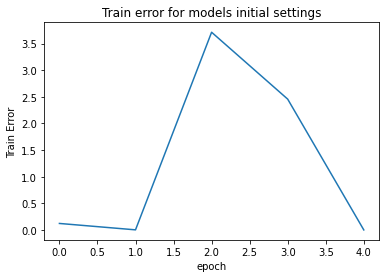

In [ ]:
#可视化模型的训练误差
plt.plot(model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')
plt.title("Train error for models initial settings")
plt.show()

### 超参数调谐  对于梯度下降算法

In [ ]:
## 超参数调谐

### 对于梯度下降算法

models = []
methods = ["Adam","RMSprop"]

In [ ]:
for method in methods:
    model = NeuralNet(
        wide_dim,
        embeddings_input,
        continuous_cols,
        deep_column_idx,
        hidden_layers,
        dropout,
        encoding_dict,
        n_class)
    model.compile(optimizer=method)
    if use_cuda:
        model = model.cuda()
    model.fit(dataset=train_dataset, n_epochs=5, batch_size=60)

    # 调参
    # model.fit(dataset=train_dataset, n_epochs=30, batch_size=60)
    models.append(model)

In [ ]:
for model in models:
    plt.plot(np.arange(5),model.loss_values)
    
    # 调参
    # plt.plot(np.arange(30),model.loss_values)
    # plt.plot(np.arange(1,5),model.loss_values[1,6])
plt.ylabel('Train Error')
plt.xlabel('epoch')
# plt.ylim(0, 100) 

plt.legend(methods, loc='upper left')
plt.title("Train error for different GD algorithms")
plt.show()

In [ ]:
for model in models:
    print("for "+ str(model.optimizer))
    y_pred = model.predict(dataset=test_dataset)
    y = test_dataset.labels
    print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
    print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

### 优化 dropout values

In [ ]:

droupouts = [0,0.1,0.5]
models_dropout=[]

In [ ]:
for droupout in droupouts:
    dropout = [droupout,droupout]
    model = NeuralNet(
        wide_dim,
        embeddings_input,
        continuous_cols,
        deep_column_idx,
        hidden_layers,
        dropout,
        encoding_dict,
        n_class)
    model.compile(optimizer="Adam")
    if use_cuda:
        model = model.cuda()
    model.fit(dataset=train_dataset, n_epochs=3, batch_size=60)
    # 调参
    # model.fit(dataset=train_dataset, n_epochs=5, batch_size=60)
    models_dropout.append(model)

Epoch 1 of 3, Loss: 0.002
Epoch 2 of 3, Loss: 0.004
Epoch 3 of 3, Loss: 5.557
Epoch 1 of 3, Loss: 0.737
Epoch 2 of 3, Loss: 0.034
Epoch 3 of 3, Loss: 0.004
Epoch 1 of 3, Loss: 0.272
Epoch 2 of 3, Loss: 0.014
Epoch 3 of 3, Loss: 0.015


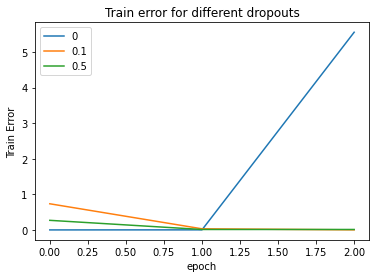

In [ ]:
for model in models_dropout:
    plt.plot(np.arange(3),model.loss_values)

    # 调参
    # plt.plot(np.arange(5),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')

plt.legend(droupouts, loc='upper left')
plt.title("Train error for different dropouts")
plt.show()

In [ ]:
# 直接显示平均值即可
for model in models_dropout:
    print("for drououts: "+ str(model.dropout))
    y_pred = model.predict(dataset=test_dataset)
    y = test_dataset.labels
    print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
    print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

for drououts: [0, 0]
test mean squared error: 15.438629721488555
test mean absolute error: 3.4647825046339924
for drououts: [0.1, 0.1]
test mean squared error: 0.014088687723436135
test mean absolute error: 0.10242017546774843
for drououts: [0.5, 0.5]
test mean squared error: 0.019370444599363525
test mean absolute error: 0.12470350097538505


### dropout调参

In [ ]:
# dropout调参
# dropout = [0.5,0.5]
dropout = [0.1,0.1]
# dropout = [0,0]
model = NeuralNet(
    wide_dim,
    embeddings_input,
    continuous_cols,
    deep_column_idx,
    hidden_layers,
    dropout,
    encoding_dict,
    n_class)
model.compile(optimizer="Adam")
if use_cuda:
    model = model.cuda()
model.fit(dataset=train_dataset, n_epochs=10, batch_size=60)

# 调参
# model.fit(dataset=train_dataset, n_epochs=30, batch_size=60)

Epoch 1 of 10, Loss: 0.008
Epoch 2 of 10, Loss: 62.351
Epoch 3 of 10, Loss: 31.505
Epoch 4 of 10, Loss: 0.005
Epoch 5 of 10, Loss: 0.101
Epoch 6 of 10, Loss: 0.009
Epoch 7 of 10, Loss: 0.009
Epoch 8 of 10, Loss: 0.106
Epoch 9 of 10, Loss: 0.0
Epoch 10 of 10, Loss: 0.004


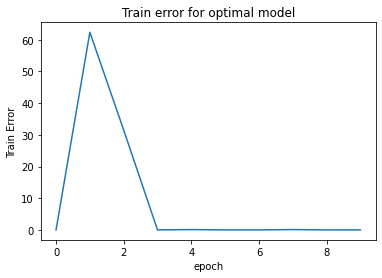

In [ ]:
plt.plot(np.arange(10),model.loss_values)

# 调参
# plt.plot(np.arange(10),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')

plt.title("Train error for optimal model")
plt.show()


### 平均值

In [ ]:
y_pred = model.predict(dataset=test_dataset)
y = test_dataset.labels
print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

test mean squared error: 0.10828367625003406
test mean absolute error: 0.2969052974913848


### 计算不同子集运行模型的时间

In [ ]:

# unique_users = final_df['user'].unique()
# user_quantiles = np.arange(0.1,1,0.1)
# runtimes = []

In [ ]:
# import time
# for quantile in user_quantiles:
#     start_time = time.time()
#     subset_users = unique_users[:int(len(unique_users)*quantile)]
#     subset_df = final_df.loc[final_df['user'].isin(subset_users)]
#     data_processed = data_processing(
#         subset_df, wide_cols,
#         embeddings_cols,
#         continuous_cols,
#         target,
#         scale=True)
#     model = NeuralNet(
#         wide_dim,
#         embeddings_input,
#         continuous_cols,
#         deep_column_idx,
#         hidden_layers,
#         dropout,
#         encoding_dict,
#         n_class)
#     model.compile(optimizer='Adam')
#     if use_cuda:
#         model = model.cuda()
#     train_dataset = data_processed['train_dataset']
#     model.fit(dataset=train_dataset, n_epochs=1, batch_size=60)
#     end_time = time.time()
#     total_time = end_time- start_time
#     print("total time:" + str(total_time))
#     runtimes.append(total_time)

Epoch 1 of 1, Loss: 64.629
total time:7.897770166397095
Epoch 1 of 1, Loss: 0.088
total time:13.298418998718262
Epoch 1 of 1, Loss: 0.144
total time:16.964170455932617
Epoch 1 of 1, Loss: 0.014
total time:19.13419270515442
Epoch 1 of 1, Loss: 0.0
total time:23.497531414031982
Epoch 1 of 1, Loss: 0.122
total time:26.43262028694153
Epoch 1 of 1, Loss: 1.469
total time:29.71981716156006
Epoch 1 of 1, Loss: 0.003
total time:32.5527606010437
Epoch 1 of 1, Loss: 0.001
total time:34.099862813949585


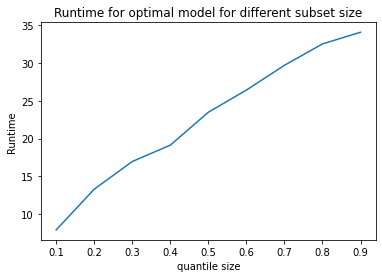

In [ ]:
# plt.plot(user_quantiles,runtimes)
# plt.ylabel('Runtime')
# plt.xlabel('quantile size')

# plt.title("Runtime for optimal model for different subset size")
# plt.show()